# HW 3 - Neural POS Tagger

In this exercise, you are going to build a set of deep learning models on part-of-speech (POS) tagging using Tensorflow 2. Tensorflow is a deep learning framwork developed by Google to provide an easier way to use standard layers and networks.

To complete this exercise, you will need to build deep learning models for POS tagging in Thai using NECTEC's ORCHID corpus. You will build one model for each of the following type:

- Neural POS Tagging with Word Embedding using Fixed / non-Fixed Pretrained weights
- Neural POS Tagging with Viterbi / Marginal CRF

Pretrained word embeddding are already given for you to use (albeit, a very bad one).

We also provide the code for data cleaning, preprocessing and some starter code for tensorflow 2 in this notebook but feel free to modify those parts to suit your needs. Feel free to use additional libraries (e.g. scikit-learn) as long as you have a model for each type mentioned above.

### Don't forget to change hardware accelrator to GPU in runtime on Google Colab ###

## 1. Setup and Preprocessing

We use POS data from [ORCHID corpus](https://www.nectec.or.th/corpus/index.php?league=pm), which is a POS corpus for Thai language.
A method used to read the corpus into a list of sentences with (word, POS) pairs have been implemented already. The example usage has shown below.
We also create a word vector for unknown word by random.

In [1]:
%tensorflow_version 2.x

In [2]:
!wget https://www.dropbox.com/s/tuvrbsby4a5axe0/resources.zip
!unzip resources.zip

--2021-02-06 01:59:12--  https://www.dropbox.com/s/tuvrbsby4a5axe0/resources.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/tuvrbsby4a5axe0/resources.zip [following]
--2021-02-06 01:59:13--  https://www.dropbox.com/s/raw/tuvrbsby4a5axe0/resources.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc27f2a02de1d4d0214ec8dc650e.dl.dropboxusercontent.com/cd/0/inline/BIYkVRILZQvSdFjmR6Gl7hvDQZ9RZmFMyuqyEmUfme8q1gBf9XTfSgSuMeJKUGHhvAue88Gs-TLkj-r1mQEdfDtMydPQ4fRTdGhtaYIStgD-ug/file# [following]
--2021-02-06 01:59:13--  https://uc27f2a02de1d4d0214ec8dc650e.dl.dropboxusercontent.com/cd/0/inline/BIYkVRILZQvSdFjmR6Gl7hvDQZ9RZmFMyuqyEmUfme8q1gBf9XTfSgSuMeJKUGHhvAue88Gs-TLkj-r1mQEdfDtMydPQ4fRTdGhtaYIStgD-ug/file
Resolving uc2

In [3]:
!pip install python-crfsuite
!pip install tensorflow-addons
!pip install tf2crf

     |████████████████████████████████| 747kB 4.2MB/s 


In [4]:
%tensorflow_version 2.x

In [5]:
from data.orchid_corpus import get_sentences
import numpy as np
import numpy.random
import tensorflow as tf
np.random.seed(42)

In [6]:
yunk_emb =np.random.randn(32)
train_data = get_sentences('train')
test_data = get_sentences('test')
print(train_data[0])

[('การ', 'FIXN'), ('ประชุม', 'VACT'), ('ทาง', 'NCMN'), ('วิชาการ', 'NCMN'), ('<space>', 'PUNC'), ('ครั้ง', 'CFQC'), ('ที่ 1', 'DONM')]


Next, we load pretrained weight embedding using pickle. The pretrained weight is a dictionary which map a word to its embedding.

In [7]:
import pickle
fp = open('basic_ff_embedding.pt', 'rb')
embeddings = pickle.load(fp)
fp.close()

The given code below generates an indexed dataset(each word is represented by a number) for training and testing data. The index 0 is reserved for padding to help with variable length sequence. (Additionally, You can read more about padding here [https://machinelearningmastery.com/data-preparation-variable-length-input-sequences-sequence-prediction/])

## 2. Prepare Data

In [8]:
word_to_idx ={}
idx_to_word ={}
label_to_idx = {}
for sentence in train_data:
    for word,pos in sentence:
        if word not in word_to_idx:
            word_to_idx[word] = len(word_to_idx)+1
            idx_to_word[word_to_idx[word]] = word
        if pos not in label_to_idx:
            label_to_idx[pos] = len(label_to_idx)+1
word_to_idx['UNK'] = len(word_to_idx)

n_classes = len(label_to_idx.keys())+1

This section is tweaked a little from the demo, word2features will return word index instead of features, and sent2labels will return a sequence of word indices in the sentence.

In [9]:
def word2features(sent, i, emb):
    word = sent[i][0]
    if word in word_to_idx :
        return word_to_idx[word]
    else :
        return word_to_idx['UNK']

def sent2features(sent, emb_dict):
    return np.asarray([word2features(sent, i, emb_dict) for i in range(len(sent))])

def sent2labels(sent):
    return numpy.asarray([label_to_idx[label] for (word, label) in sent],dtype='int32')

def sent2tokens(sent):
    return [word for (word, label) in sent]

In [10]:
sent2features(train_data[100], embeddings)

array([ 29, 327,   5, 328])

Next we create train and test dataset, then we use tensorflow 2 to post-pad the sequence to max sequence with 0. Our labels are changed to a one-hot vector.

In [11]:
%%time
x_train = np.asarray([sent2features(sent, embeddings) for sent in train_data])
y_train = [sent2labels(sent) for sent in train_data]
x_test = [sent2features(sent, embeddings) for sent in test_data]
y_test = [sent2labels(sent) for sent in test_data]

CPU times: user 334 ms, sys: 571 µs, total: 334 ms
Wall time: 338 ms


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [12]:
x_train[100]

array([ 29, 327,   5, 328])

In [13]:
x_train.shape

(18500,)

In [14]:
y_train[100]

array([ 3, 10,  4,  3], dtype=int32)

In [15]:
len(y_train)

18500

In [16]:
x_train=tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=None, dtype='int32', padding='post', truncating='pre', value=0.)
y_train=tf.keras.preprocessing.sequence.pad_sequences(y_train, maxlen=None, dtype='int32', padding='post', truncating='pre', value=0.)
x_test=tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=102, dtype='int32', padding='post', truncating='pre', value=0.)
# y_temp =[]
# for i in range(len(y_train)):
#     y_temp.append(np.eye(n_classes)[y_train[i]][np.newaxis,:])
# y_train = np.asarray(y_temp).reshape(-1,102,n_classes)
# del(y_temp)

In [17]:
y_train[100]

array([ 3, 10,  4,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

In [18]:
y_train.shape

(18500, 102)

In [19]:
y_temp =[]
for i in range(len(y_train)):
    y_temp.append(np.eye(n_classes)[y_train[i]][np.newaxis,:])
y_train = np.asarray(y_temp).reshape(-1,102,n_classes)
del(y_temp)

In [20]:
print(x_train[100],x_train.shape)
print(y_train[100][3],y_train.shape)

[ 29 327   5 328   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] (18500, 102)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] (18500, 102, 48)


## 3. Evaluate

Our output from tf keras is a distribution of problabilities on all possible label. outputToLabel will return an indices of maximum problability from output sequence.

evaluation_report is the same as in the demo

In [21]:
def outputToLabel(yt,seq_len):
    out = []
    for i in range(0,len(yt)):
        if(i==seq_len):
            break
        out.append(np.argmax(yt[i]))
    return out

In [22]:
import pandas as pd
from IPython.display import display

def evaluation_report(y_true, y_pred):
    # retrieve all tags in y_true
    tag_set = set()
    for sent in y_true:
        for tag in sent:
            tag_set.add(tag)
    for sent in y_pred:
        for tag in sent:
            tag_set.add(tag)
    tag_list = sorted(list(tag_set))
    
    # count correct points
    tag_info = dict()
    for tag in tag_list:
        tag_info[tag] = {'correct_tagged': 0, 'y_true': 0, 'y_pred': 0}

    all_correct = 0
    all_count = sum([len(sent) for sent in y_true])
    for sent_true, sent_pred in zip(y_true, y_pred):
        for tag_true, tag_pred in zip(sent_true, sent_pred):
            if tag_true == tag_pred:
                tag_info[tag_true]['correct_tagged'] += 1
                all_correct += 1
            tag_info[tag_true]['y_true'] += 1
            tag_info[tag_pred]['y_pred'] += 1
    accuracy = (all_correct / all_count) * 100
            
    # summarize and make evaluation result
    eval_list = list()
    for tag in tag_list:
        eval_result = dict()
        eval_result['tag'] = tag
        eval_result['correct_count'] = tag_info[tag]['correct_tagged']
        precision = (tag_info[tag]['correct_tagged']/tag_info[tag]['y_pred'])*100 if tag_info[tag]['y_pred'] else '-'
        recall = (tag_info[tag]['correct_tagged']/tag_info[tag]['y_true'])*100 if (tag_info[tag]['y_true'] > 0) else 0
        eval_result['precision'] = precision
        eval_result['recall'] = recall
        eval_result['f_score'] = (2*precision*recall)/(precision+recall) if (type(precision) is float and recall > 0) else '-'
        
        eval_list.append(eval_result)

    eval_list.append({'tag': 'accuracy=%.2f' % accuracy, 'correct_count': '', 'precision': '', 'recall': '', 'f_score': ''})
    
    df = pd.DataFrame.from_dict(eval_list)
    df = df[['tag', 'precision', 'recall', 'f_score', 'correct_count']]
    display(df)

## 4. Train a model

In [23]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dense,GRU,Reshape,TimeDistributed,Bidirectional,Dropout,Masking
from tensorflow.keras.optimizers import Adam

The model is this section is separated to two groups

- Neural POS Tagger (4.1)
- Neural CRF POS Tagger (4.2)

## 4.1.1 Neural POS Tagger  (Example)

We create a simple Neural POS Tagger as an example for you. This model dosen't use any pretrained word embbeding so it need to use Embedding layer to train the word embedding from scratch.

Instead of using tensorflow.keras.models.Sequential, we use tensorflow.keras.models.Model. The latter is better as it can have multiple input/output, of which Sequential model could not. Due to this reason, the Model class is widely used for building a complex deep learning model.

In [24]:
inputs = Input(shape=(102,), dtype='int32')
output = (Embedding(len(word_to_idx),32,input_length=102,mask_zero=True))(inputs)
output = Bidirectional(GRU(32, return_sequences=True))(output)
output = Dropout(0.2)(output)
output = TimeDistributed(Dense(n_classes,activation='softmax'))(output)
model = Model(inputs, output)
model.compile(optimizer=Adam(lr=0.001),  loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()
model.fit(x_train,y=y_train, batch_size=64,epochs=10,verbose=1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 102)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 102, 32)           480608    
_________________________________________________________________
bidirectional (Bidirectional (None, 102, 64)           12672     
_________________________________________________________________
dropout (Dropout)            (None, 102, 64)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 102, 48)           3120      
Total params: 496,400
Trainable params: 496,400
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
290/290 [==============================] - 43s 126ms/step - loss: 0.3892 - categorical_accuracy: 0.3933
Epoch 

In [25]:
%%time
model.fit(x_train,y_train,batch_size=64,epochs=10,verbose=1)

Epoch 1/10
290/290 [==============================] - 36s 124ms/step - loss: 0.0174 - categorical_accuracy: 0.9630
Epoch 2/10
290/290 [==============================] - 44s 153ms/step - loss: 0.0167 - categorical_accuracy: 0.9645
Epoch 3/10
290/290 [==============================] - 36s 125ms/step - loss: 0.0162 - categorical_accuracy: 0.9657
Epoch 4/10
290/290 [==============================] - 37s 126ms/step - loss: 0.0156 - categorical_accuracy: 0.9667
Epoch 5/10
290/290 [==============================] - 36s 124ms/step - loss: 0.0151 - categorical_accuracy: 0.9676
Epoch 6/10
290/290 [==============================] - 36s 124ms/step - loss: 0.0147 - categorical_accuracy: 0.9685
Epoch 7/10
290/290 [==============================] - 36s 123ms/step - loss: 0.0142 - categorical_accuracy: 0.9698
Epoch 8/10
290/290 [==============================] - 36s 122ms/step - loss: 0.0138 - categorical_accuracy: 0.9701
Epoch 9/10
290/290 [==============================] - 36s 123ms/step - loss: 0.0

In [26]:
%%time
#model.save_weights('/data/my_pos_no_crf.h5')
#model.load_weights('/data/my_pos_no_crf.h5')
y_pred = model.predict(x_test)
ypred = [outputToLabel(y_pred[i],len(y_test[i])) for i in range(len(y_pred))]
evaluation_report(y_test, ypred)

,tag,precision,recall,f_score,correct_count
0,1,99.7827,99.6744,99.7285,3673
1,2,95.0507,93.1377,94.0845,7682
2,3,90.8203,95.7783,93.2334,16176
3,4,99.9457,99.675,99.8101,12880
4,5,100,98.5075,99.2481,66
5,6,99.7835,88.3142,93.6992,461
6,7,98.1077,97.2583,97.6812,2022
7,8,71.7608,52.0482,60.3352,216
8,9,63.3952,64.9457,64.1611,239
9,10,61.3402,42.5507,50.2463,357


CPU times: user 7.26 s, sys: 390 ms, total: 7.65 s
Wall time: 5.45 s


In [27]:
y_pred.shape

(4625, 102, 48)

In [28]:
len(ypred[100])

9

In [29]:
ypred[0]

[34, 4, 1, 2, 3, 3, 4, 3, 3, 13, 4, 3, 21, 2, 2, 3]

In [30]:
y_test[0]

array([34,  4,  1,  2,  3,  3,  4,  3,  3, 13,  4,  3, 21,  2,  2,  3],
      dtype=int32)

In [31]:
# model.fit(x_train,y=y_train, batch_size=64,epochs=2,verbose=1)

In [32]:
model.save_weights('/data/my_pos_no_crf')
model.load_weights('/data/my_pos_no_crf')

In [129]:
# y_pred = model.predict(x_test)
# ypred = [outputToLabel(y_pred[i],len(y_test[i])) for i in range(len(y_pred))]
# evaluation_report(y_test, ypred)

## 4.2 CRF Viterbi

Your next task is to incorporate Conditional random fields (CRF) to your model.

To use the CRF layer, you need to use an extension repository for tensorflow library, call tf2crf. If you want to see the detailed implementation, you should read the official tensorflow extention of CRF (https://www.tensorflow.org/addons/api_docs/python/tfa/text).

tf2crf link :  https://github.com/xuxingya/tf2crf

For inference, you should look at crf.py at the method call and view the input/output argmunets. 
Link : https://github.com/xuxingya/tf2crf/blob/master/tf2crf/crf.py



### 4.2.1 CRF without pretrained weight
### #TODO 1
Incoperate CRF layer to your model in 4.1. CRF is quite complex compare to previous example model, so you should train it with more epoch, so it can converge.

To finish this excercise you must train the model and show the evaluation report with this model as shown in the example.

Do not forget to save this model weight.

In [34]:
# INSERT YOUR CODE HERE
from tf2crf import CRF, ModelWithCRFLoss

In [35]:
%%time
x_train = np.asarray([sent2features(sent, embeddings) for sent in train_data])
y_train = [sent2labels(sent) for sent in train_data]
x_test = [sent2features(sent, embeddings) for sent in test_data]
y_test = [sent2labels(sent) for sent in test_data]

CPU times: user 319 ms, sys: 3.03 ms, total: 322 ms
Wall time: 322 ms


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [36]:
x_train=tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=None, dtype='int32', padding='post', truncating='pre', value=0.)
y_train=tf.keras.preprocessing.sequence.pad_sequences(y_train, maxlen=None, dtype='int32', padding='post', truncating='pre', value=0.)
x_test=tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=102, dtype='int32', padding='post', truncating='pre', value=0.)

In [37]:
inputs = Input(shape=(102,), dtype='int32')
output = (Embedding(len(word_to_idx),32,input_length=102,mask_zero=True))(inputs)
output = Bidirectional(GRU(32, return_sequences=True))(output)
output = Dropout(0.2)(output)
output = TimeDistributed(Dense(n_classes,activation=None))(output)
# output = Dense(n_classes, activation=None)(output)
crf = CRF(dtype='float32')
output = crf(output)
base_model = Model(inputs, output)
model = ModelWithCRFLoss(base_model)
model.compile(optimizer=Adam(lr=0.001),  loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# model.summary()
base_model.summary()
model.fit(x_train,y=y_train, batch_size=64,epochs=20,verbose=1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 102)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 102, 32)           480608    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 102, 64)           12672     
_________________________________________________________________
dropout_1 (Dropout)          (None, 102, 64)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 102, 48)           3120      
_________________________________________________________________
crf (CRF)                    ((None, 102), (None, 102, 2306      
Total params: 498,706
Trainable params: 498,704
Non-trainable params: 2
_____________________________________________________

In [38]:
# from google.colab import drive
# drive.mount('/content/drive')

In [39]:
# model.save_weights('/data/my_pos_421_crf_wo_pretrain_wt.h5')

In [40]:
%%time
model.save_weights('/data/my_pos_421_crf_wo_pretrain_wt')
model.load_weights('/data/my_pos_421_crf_wo_pretrain_wt')
y_pred=model.predict(x_test)
ypred = [outputToLabel(y_pred[1][i],len(y_test[i])) for i in range(len(y_pred[1]))]
evaluation_report(y_test, ypred)

,tag,precision,recall,f_score,correct_count
0,1,99.8911,99.5929,99.7418,3670
1,2,94.1573,94.7624,94.4589,7816
2,3,90.0479,96.7553,93.2812,16341
3,4,99.9301,99.5821,99.7558,12868
4,5,95.4545,94.0299,94.7368,63
5,6,97.8992,89.272,93.3868,466
6,7,98.0164,97.4507,97.7328,2026
7,8,67.7326,56.1446,61.3966,233
8,9,78.1481,57.337,66.1442,211
9,10,60.708,40.882,48.8604,343


CPU times: user 17.5 s, sys: 1.05 s, total: 18.5 s
Wall time: 11.4 s



### 4.2.2 CRF with pretrained weight

### #TODO 2

We would like you create a neural CRF POS tagger model  with the pretrained word embedding as an input and the word embedding is trainable (not fixed). To finish this excercise you must train the model and show the evaluation report with this model as shown in the example.

Please note that the given pretrained word embedding only have weights for the vocabuary in BEST corpus.

Optionally, you can use your own pretrained word embedding.

#### Hint: You can get the embedding from get_embeddings function from embeddings/emb_reader.py . 

(You may want to read about Tensorflow Masking layer and Trainable parameter)

In [41]:
# INSERT YOUR CODE HERE

In [42]:
# model.load_weights('/data/my_pos_421_crf_wo_pretrain_wt.h5')

In [43]:
# model.get_weights()

In [44]:
# embeddings

In [45]:
# !python embeddings/emb_reader.py  

In [46]:
import sys
sys.path.insert(0,'embeddings')

In [47]:
from emb_reader import get_embeddings

In [48]:
embeddings_index = get_embeddings()

In [49]:
# embeddings_index.get('ดิวิชั่น')

In [50]:
# len(word_to_idx)

In [51]:
# word_to_idx['UNK']

In [52]:
embedding_matrix = np.zeros((len(word_to_idx), 64))

for word, i in word_to_idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [53]:
# embedding_matrix.shape

In [54]:
inputs = Input(shape=(102,), dtype='int32')
output = (Embedding(len(word_to_idx),64,input_length=102,mask_zero=True,weights=[embedding_matrix], trainable=True))(inputs)
output = Bidirectional(GRU(64, return_sequences=True))(output)
output = Dropout(0.2)(output)
output = TimeDistributed(Dense(n_classes,activation=None))(output)
# output = Dense(n_classes, activation=None)(output)
crf = CRF(dtype='float32')
output = crf(output)
base_model = Model(inputs, output)
model = ModelWithCRFLoss(base_model)
model.compile(optimizer=Adam(lr=0.001),  loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# model.summary()
base_model.summary()
model.fit(x_train,y=y_train, batch_size=64,epochs=20,verbose=1)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 102)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 102, 64)           961216    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 102, 128)          49920     
_________________________________________________________________
dropout_2 (Dropout)          (None, 102, 128)          0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 102, 48)           6192      
_________________________________________________________________
crf_1 (CRF)                  ((None, 102), (None, 102, 2306      
Total params: 1,019,634
Trainable params: 1,019,632
Non-trainable params: 2
_________________________________________________

In [55]:
%%time
model.save_weights('/data/my_pos_422_crf_w_pretrain_wt')
model.load_weights('/data/my_pos_422_crf_w_pretrain_wt')
y_pred=model.predict(x_test)
ypred = [outputToLabel(y_pred[1][i],len(y_test[i])) for i in range(len(y_pred[1]))]
evaluation_report(y_test, ypred)

,tag,precision,recall,f_score,correct_count
0,1,99.8638,99.4573,99.6601,3665
1,2,95.1367,91.5495,93.3086,7551
2,3,91.5937,93.481,92.5277,15788
3,4,99.9379,99.5898,99.7636,12869
4,5,95.5882,97.0149,96.2963,65
5,6,95.0495,91.954,93.4761,480
6,7,97.1306,97.6912,97.4101,2031
7,8,65.4723,48.4337,55.6787,201
8,9,56.5321,64.6739,60.3295,238
9,10,62.9758,43.385,51.3761,364


CPU times: user 19.8 s, sys: 959 ms, total: 20.8 s
Wall time: 12.8 s


### #TODO 3
Compare the result between all neural tagger models in 4.1 and 4.2.x and provide a convincing reason and example for the result of these models (which model perform better, why?)

(If you use your own weight please state so in the answer)

<b>Write your answer here :</b>

The accuracy among neural taggers models in 4.1, 4.2.1, 4.2.2 are not significantly different. I would suggest to use Neural POS Tagger without CRF in 4.1 because it is faster for model training.

However, if we observe the PoS with low data point such as tag No. 41, 42, 43 that Neural POS Tagger without CRF in 4.1 pridict very low correct_count. The Neural POS Tagger with CRF in 4.2.x perform better. If we require correction of these rare PoS, we may consider to use Neural POS Tagger with CRF but if not, I would suggest to use Neural POS Tagger without CRF in 4.1 because it is faster for model training.


---




### #TODO 4

Upon inference, the model also returns its transition matrix, which is learned during training. Your task is to observe and report whether the returned matrix is sensible. You can provide some examples to support your argument.

#### Hint : The transition matrix must have the shape  of (num_class, num_class).

<b>Write your answer here :</b>

In [60]:
# INSERT YOUR CODE HERE IF NEEDED

- From transition matrix 'FIXV' and 'VSTA' have quite high value (1.08) comparing to other pairs of PoS. 
  - FIXV is Adverbial prefix such as โดย, อย่าง
  - VSTA is	Stative verb such as มี, อาศัย, เห็น, รู้, คือ
  - Thus, it is high probability that FIXV will be followed by VSTA. (Adv + v)
  - The high value in transition matix of this pair is sensible

- From transition matrix 'FIXV' and 'ADVN' have quite low value (-1.85) comparing to other pairs of PoS. 
  - FIXV is Adverbial prefix such as โดย, อย่าง
  - ADVN is Adverb with normal form such as ยิ่งขึ้น, สืบไป, ตลอดไป
  - Thus, it is low probability that FIXV will be followed by ADVN.
  - The low value in transition matix of this pair is sensible

https://thainlp.org/pythainlp/docs/2.1/api/tag.html

In [68]:
crf.transitions

<tf.Variable 'crf_1/transitions:0' shape=(48, 48) dtype=float32, numpy=
array([[ 0.17289428, -0.36795548, -0.19785218, ..., -0.12990582,
        -0.04271043,  0.1992727 ],
       [-0.11040729,  0.10168601,  0.44525266, ...,  0.06120352,
        -0.03423706,  0.00378226],
       [ 0.23601711,  0.22718391, -0.73794305, ..., -0.5132671 ,
         0.24646789, -0.34030148],
       ...,
       [-0.00717268, -0.11334614, -0.26073828, ..., -0.09635121,
         0.0860517 , -0.00532945],
       [-0.24167477, -0.09742437, -0.19529629, ..., -0.11261982,
        -0.05842242, -0.32638347],
       [ 0.02762382,  0.12250203,  0.1008921 , ..., -0.11433423,
        -0.11326311, -0.03555876]], dtype=float32)>

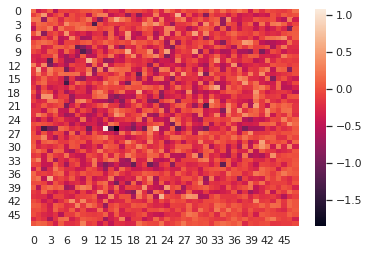

In [69]:
import seaborn as sns; sns.set_theme()
ax = sns.heatmap(crf.transitions)

In [75]:
# find outlier data point in row 26
crf.transitions[26]

<tf.Tensor: shape=(48,), dtype=float32, numpy=
array([-0.09235834, -0.32190788, -1.3435528 , -0.93988675, -0.82652587,
        0.15363856,  0.04388098, -0.2248343 , -0.11823319, -0.23810074,
       -0.98710024, -0.24749543, -0.4019449 ,  1.0769099 , -1.195432  ,
       -1.8525116 , -0.4619164 , -0.61974686, -0.9203204 , -0.46292874,
       -0.9920386 ,  0.2513609 ,  0.73696077, -0.59892845, -0.5016034 ,
        0.07065988, -1.0597429 , -0.5347772 , -0.15752304, -0.5695842 ,
       -0.64109755, -0.94726473, -0.30550343, -0.32523343, -0.12005069,
       -0.35288814,  0.20207728, -0.49406096, -0.9376122 , -0.5854673 ,
       -0.6157715 , -0.5668478 , -0.17913917, -0.34607348, -0.07350519,
       -0.22599672, -0.14084482,  0.03805586], dtype=float32)>

In [135]:
crf.transitions[26][13]

<tf.Tensor: shape=(), dtype=float32, numpy=1.0769099>

In [114]:
crf.transitions[26][15]

<tf.Tensor: shape=(), dtype=float32, numpy=-1.8525116>

In [110]:
# for i in range(len(model.get_weights())):
#   print(i)
#   print(model.get_weights()[i].shape)

In [111]:
# model.get_weights()[9]

In [116]:
label_to_idx

{'ADVI': 35,
 'ADVN': 15,
 'ADVP': 33,
 'ADVS': 38,
 'CFQC': 5,
 'CLTV': 32,
 'CMTR': 25,
 'CMTR@PUNC': 36,
 'CNIT': 9,
 'CVBL': 47,
 'DCNM': 24,
 'DDAC': 17,
 'DDAN': 31,
 'DDAQ': 43,
 'DDBQ': 39,
 'DIAC': 29,
 'DIAQ': 46,
 'DIBQ': 20,
 'DONM': 6,
 'EAFF': 45,
 'EITT': 42,
 'FIXN': 1,
 'FIXV': 26,
 'JCMP': 37,
 'JCRG': 7,
 'JSBR': 16,
 'NCMN': 3,
 'NCNM': 8,
 'NEG': 40,
 'NLBL': 34,
 'NONM': 44,
 'NPRP': 10,
 'NTTL': 11,
 'PDMN': 30,
 'PNTR': 41,
 'PPRS': 27,
 'PREL': 21,
 'PUNC': 4,
 'RPRE': 14,
 'VACT': 2,
 'VATT': 22,
 'VSTA': 13,
 'XVAE': 23,
 'XVAM': 12,
 'XVBB': 28,
 'XVBM': 18,
 'XVMM': 19}

In [117]:
label_to_idx['VSTA']

13

In [118]:
label_to_idx['FIXV']

26

In [119]:
label_to_idx['ADVN']

15

In [120]:
# train_data[0][1][1]

In [130]:
def example_pos(data, pos, n = 15):
  k = 0
  for i, row in enumerate(data):
    if k >= n:
      break
    for j, word in enumerate(row):
      # print(word[0])
      # print(word[1])
      if word[1] == pos:
        print(word[1] + " : " + word[0])
        k = k + 1

In [131]:
example_pos(train_data,'VSTA')
print('\n')
example_pos(train_data,'FIXV')
print('\n')
example_pos(train_data,'ADVN')

VSTA : มี
VSTA : เป็น
VSTA : บรรลุ
VSTA : อาศัย
VSTA : เป็น
VSTA : เป็น
VSTA : เป็น
VSTA : มี
VSTA : เป็น
VSTA : มี
VSTA : มี
VSTA : มี
VSTA : มี
VSTA : เป็น
VSTA : มี


FIXV : โดย
FIXV : อย่าง
FIXV : อย่าง
FIXV : โดย
FIXV : อย่าง
FIXV : อย่าง
FIXV : อย่าง
FIXV : อย่าง
FIXV : อย่าง
FIXV : โดย
FIXV : อย่าง
FIXV : เป็น
FIXV : โดย
FIXV : อย่าง
FIXV : โดย


ADVN : มาก
ADVN : ยิ่งขึ้น
ADVN : มาก
ADVN : มหาศาล
ADVN : ด้วย
ADVN : ยิ่งขึ้น
ADVN : สืบไป
ADVN : แน่
ADVN : ตลอดไป
ADVN : ที่สุด
ADVN : มาก
ADVN : มาก
ADVN : ที่สุด
ADVN : ด้วย
ADVN : เสมอ
